In [1]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import scipy
import copy
import sys
import os
from typing import Optional, Union, Sequence, Mapping, List, Set
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from matplotlib.lines import Line2D
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from scipy.stats import sem
from matplotlib.ticker import FormatStrFormatter

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_shapes,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average,geometric_difference,geometric_distance,grassmann_distance
from quantum_kernel.code.kernel_measures.eigenvalue_scaling import get_eigenvalue_scaling,compute_dataframe_kernel_eigenvalues

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 30}

rc('font', **font)

tqdm.pandas()
warnings.filterwarnings("ignore")


In [2]:
save_folder='/mnt/c/Users/lslat/Data/QK_project/results/figs/'

In [3]:
def dict_to_plot_data(dict1):
    xs=[]
    ys=[]
    yerrs=[]
    for key in dict1:
        y=np.mean(dict1[key])
        yerr=sem(dict1[key])
        xs.append(int(key))
        ys.append(y)
        yerrs.append(yerr)
    return xs,ys,yerrs

In [4]:
def find_min_in_dict_to_plot_data(dict1):
    xs=[]
    ys=[]
    yerrs=[]
    for key in dict1:
        x=list(set(dict1[key][:,0]))
        y=min([np.mean(dict1[key][dict1[key][:,0]==a][:,1]) for a in x])
        index = [np.mean(dict1[key][dict1[key][:,0]==a][:,1]) for a in x].index(y)
        yerr=[sem(dict1[key][dict1[key][:,0]==a][:,1]) for a in x][index]
        xs.append(int(key))
        ys.append(y)
        yerrs.append(yerr)
    return xs,ys,yerrs

In [5]:
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/HZZ_multi/fashion-mnist/matrix_size_test2.0/",'HZZ_Multi'),
]

cols_to_drop=['args', 'K_train_time', 
'samples', 'mu','sigma', 'outpath','qkern_matrix_test']

def get_dfs_from_folder(folder,prefix,cols_to_drop):
    dfs={}
    dfs[prefix] = aggregate_shapes(folder,prefix,cols_to_drop=cols_to_drop)
    return dfs

dfs_list=[get_dfs_from_folder(folder[0],folder[1],cols_to_drop) for folder in folders]

In [6]:
df=dfs_list[0]

In [7]:
c_df=df['HZZ_Multi'][(df['HZZ_Multi']['h_layer']==0)]
q_df=df['HZZ_Multi'][(df['HZZ_Multi']['h_layer']==1)]

In [8]:
sizes=set(q_df.matrix_size.values)
split_idxs=set(q_df.split_index.values)

qeigs={}
ceigs={}
qscores={}
cscores={}
qsfs={}
csfs={}
gdcs={}
rgdcs={}
gdists={}

for matrix_size in sizes:
    qeigs[str(matrix_size)]=[]
    ceigs[str(matrix_size)]=[]
    qscores[str(matrix_size)]=[]
    cscores[str(matrix_size)]=[]
    qsfs[str(matrix_size)]=[]
    csfs[str(matrix_size)]=[]
    gdcs[str(matrix_size)]=[]
    rgdcs[str(matrix_size)]=[]
    gdists[str(matrix_size)]=[]
    for split_idx in split_idxs:
        try:
            q_row_idx=q_df.query(f'matrix_size=={matrix_size} and split_index=={split_idx}')['tuned_test_score'].idxmax()
        except:
            continue
        max_eig = q_df['kernel_eigenvalues'][q_row_idx][0]
        score=q_df['tuned_test_score'][q_row_idx]
        sf=q_df['scaling_factor'][q_row_idx]
        qeigs[str(matrix_size)].append(max_eig)
        qscores[str(matrix_size)].append(score)
        qsfs[str(matrix_size)].append(sf)

        c_row_idx=c_df.query(f'matrix_size=={matrix_size} and split_index=={split_idx}')['tuned_test_score'].idxmax()
        max_eig = c_df['kernel_eigenvalues'][c_row_idx][0]
        score=c_df['tuned_test_score'][c_row_idx]
        sf=c_df['scaling_factor'][c_row_idx]
        
        ceigs[str(matrix_size)].append(max_eig)
        cscores[str(matrix_size)].append(score)
        csfs[str(matrix_size)].append(sf)
        
        Kq=q_df['qkern_matrix_train'][q_row_idx]
        Kc=c_df['qkern_matrix_train'][c_row_idx]

        gd=geometric_difference(Kq,Kc)
        rgd=geometric_difference(Kc,Kq)
        gdist=geometric_distance(Kq,Kc)

        gdcs[str(matrix_size)].append(gd)
        rgdcs[str(matrix_size)].append(rgd)
        gdists[str(matrix_size)].append(gdist)

In [9]:
sizes=set(q_df.matrix_size.values)
split_idxs=set(q_df.split_index.values)

filepath=save_folder+f'geometric_difference_dict_fashion-mnist_data_ms2.0.p'
if os.path.exists(filepath):
    with open(filepath, 'rb') as pickle_file:
        geo_diffs=pickle.load(pickle_file)
else:
    geo_diffs={}
    for size in sizes:
        print(f'on size: {size}')
        geo_diffs[str(size)]=[]
        for split_idx in split_idxs:
            q_row_idx=q_df.query(f'matrix_size=={size} and split_index=={split_idx}')['tuned_test_score'].idxmax()
            sub_c_df=c_df.query(f'matrix_size=={size} and split_index=={split_idx}')
            Kq=q_df['qkern_matrix_train'][q_row_idx]
            Kcs=sub_c_df['qkern_matrix_train'].values
            sfs=sub_c_df['scaling_factor'].values
            geo_diffs[str(size)]=geo_diffs[str(size)]+[(sf,geometric_difference(Kc,Kq)) for sf,Kc in zip(sfs,Kcs)]
        geo_diffs[str(size)]=np.array(geo_diffs[str(size)])

with open(filepath, 'wb') as f:
    try:
        pickle.dump(geo_diffs,f)
    except:
        print('Could not save geo_diffs dictionary')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


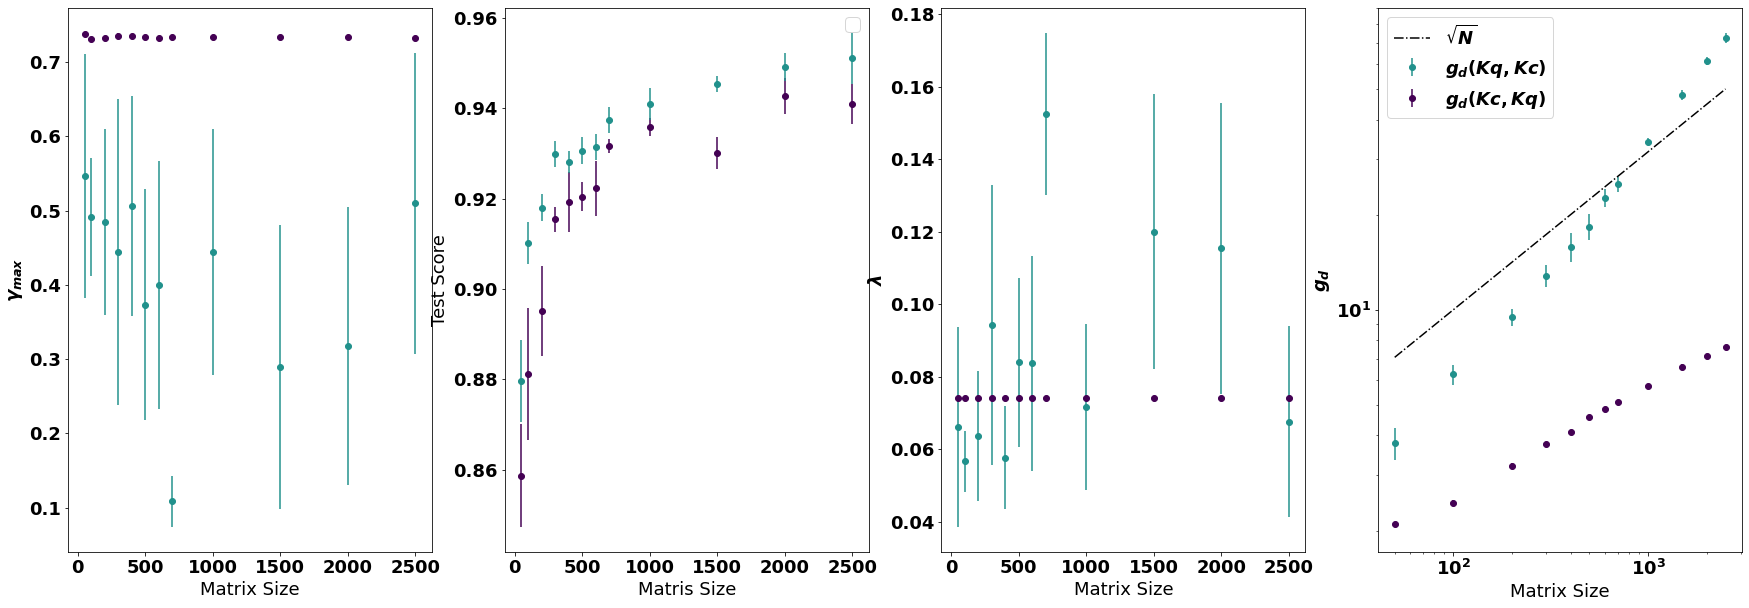

In [16]:
q_color=cm.viridis(0)
c_color=cm.viridis(128)
rbf_color=cm.viridis(255)

plt.rc('font', size=18)
s=100

fig, axs = plt.subplots(1,4,figsize=(30,10))
axs[0].set_ylabel(r'$\gamma_{max}$')
axs[0].set_xlabel('Matrix Size')
axs[1].set_ylabel('Test Score')
axs[1].set_xlabel('Matrix Size')
axs[2].set_ylabel(r'$\lambda$')
axs[2].set_xlabel('Matrix_Size')
axs[3].set_ylabel('$g_d$')
axs[3].set_xlabel('Matrix Size')

axs[1].set_ylabel('Test Score')
axs[1].set_xlabel('Matris Size')
axs[2].set_ylabel(r'$\lambda$')

axs[2].set_xlabel('Matrix Size')
axs[3].set_ylabel('$g_d$')
axs[3].set_xlabel('Matrix Size')

axs[0].errorbar(*dict_to_plot_data(qeigs),color=q_color,fmt='o')
axs[0].errorbar(*dict_to_plot_data(ceigs),color=c_color,fmt='o')

axs[1].errorbar(*dict_to_plot_data(qscores),color=q_color,fmt='o')
axs[1].errorbar(*dict_to_plot_data(cscores),color=c_color,fmt='o')

axs[2].errorbar(*dict_to_plot_data(qsfs),color=q_color,fmt='o')
axs[2].errorbar(*dict_to_plot_data(csfs),color=c_color,fmt='o')

#axs[3].errorbar(*dict_to_plot_data(gdcs),color=cm.viridis(64),fmt='o')
axs[3].errorbar(*find_min_in_dict_to_plot_data(geo_diffs),color=cm.viridis(128),fmt='o',label=r'$g_d(Kq,Kc)$')
axs[3].plot(np.sort(list(sizes)),np.sqrt(np.sort(list(sizes))),ls='-.',label=r'$\sqrt{N}$',color='black')
axs[3].set_yscale('log')
axs[3].set_xscale('log')
axs[1].legend()
axs[3].legend()